In [67]:
import cdflib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import os
import astropy.constants as constant
from scipy.interpolate import griddata

In [3]:
pas_l2_dir = r'C:\Users\qiyyc\PycharmProjects\sc_data\solar_orbiter_data\swa\science\l2\pas-vdf'
pas_name = 'solo_l2_swa-pas-vdf_20200714_v02.cdf'
pas_file = os.path.join(pas_l2_dir, pas_name)

data = cdflib.CDF(pas_file)

In [6]:
thetabin = data.varget('nb_Energy')

In [7]:
epoch = data.varget('Epoch')
vdf_time = cdflib.cdfepoch.to_datetime(epoch)
energybin = data.varget('Energy')  #'UNITS': 'eV'
thetabin = data.varget('Elevation')
phibin = data.varget('Azimuth')
rotmat_rtn_inst = data.varget('PAS_to_RTN')
vdf = data.varget('vdf')  #Units: 'eV/cm2-s-ster-eV'
speedbin = np.sqrt(2 * energybin * constant.e.value / constant.m_p.value) / 1000  # km/s

In [8]:
itime = 8053
vdf_temp = vdf[itime,:,:,:]

In [9]:
ele_arr = np.tile(thetabin[None, :, None], (11, 1, 96))
azi_arr = np.tile(phibin[:, None, None], (1, 9, 96))
vel_arr = np.tile(speedbin[None, None, :], (11, 9, 1))
vx = -np.cos(np.deg2rad(ele_arr)) * np.cos(np.deg2rad(azi_arr)) * vel_arr
vy = -np.cos(np.deg2rad(ele_arr)) * np.sin(np.deg2rad(azi_arr)) * vel_arr
vz = np.sin(np.deg2rad(ele_arr)) * vel_arr

In [35]:
good_ind = vdf_temp>0
vx_good = vx[good_ind]
vy_good = vy[good_ind]
vz_good = vz[good_ind]
vdf_good = vdf_temp[good_ind]

In [36]:
x_train = np.array([vx_good,vy_good,vz_good]).T

In [61]:
print([vx_good.max(),vx_good.min(),vy_good.max(),vy_good.min(),vz_good.max(),vz_good.min()])

[-216.02109, -871.6146, 141.4622, -459.99298, 316.0345, -177.54456]


In [93]:
vx_lst,vy_lst,vz_lst = np.linspace(-200,-900,71),np.linspace(-450,150,51),np.linspace(-200,300,51)
vx_arr,vy_arr,vz_arr = np.meshgrid(vx_lst,vy_lst,vz_lst,indexing='ij')
xi = np.array([vx_arr.ravel(),vy_arr.ravel(),vz_arr.ravel()]).T

In [94]:
clf = GaussianMixture(n_components=3,covariance_type='full')
clf.fit(x_train)
x_test = np.array([vx.ravel(),vy.ravel(),vz.ravel()]).T
g_prob = clf.predict_proba(x_test)


In [105]:
g1_vdf = vdf_temp*g_prob[:,0].reshape([11,9,96])
g2_vdf = vdf_temp*g_prob[:,1].reshape([11,9,96])
g3_vdf = vdf_temp*g_prob[:,2].reshape([11,9,96])
grid_g1_vdf = (griddata(x_test,g1_vdf.ravel(),xi,method='linear',fill_value=0.0)).reshape([71,51,51])
grid_g2_vdf = (griddata(x_test,g2_vdf.ravel(),xi,method='linear',fill_value=0.0)).reshape([71,51,51])
grid_g3_vdf = (griddata(x_test,g3_vdf.ravel(),xi,method='linear',fill_value=0.0)).reshape([71,51,51])
grid_vdf = (griddata(x_test,vdf_temp.ravel(),xi,method='linear',fill_value=0.0)).reshape([71,51,51])

C:\Users\qiyyc\AppData\Local\Temp\ipykernel_9704\3917853178.py:3: RuntimeWarning: divide by zero encountered in log10
  cax=axs[0][0].pcolor(-vx_lst,vy_lst,np.log10(grid_vdf[:,:,25]).T,cmap='jet',vmin=-14,vmax=-8)
C:\Users\qiyyc\AppData\Local\Temp\ipykernel_9704\3917853178.py:6: RuntimeWarning: divide by zero encountered in log10
  axs[0][1].pcolor(-vx_lst,vy_lst,np.log10(grid_g1_vdf[:,:,25]).T,cmap='jet',vmin=-14,vmax=-8)
C:\Users\qiyyc\AppData\Local\Temp\ipykernel_9704\3917853178.py:8: RuntimeWarning: divide by zero encountered in log10
  axs[1][0].pcolor(-vx_lst,vy_lst,np.log10(grid_g2_vdf[:,:,25]).T,cmap='jet',vmin=-14,vmax=-8)
C:\Users\qiyyc\AppData\Local\Temp\ipykernel_9704\3917853178.py:12: RuntimeWarning: divide by zero encountered in log10
  axs[1][1].pcolor(-vx_lst,vy_lst,np.log10(grid_g3_vdf[:,:,25]).T,cmap='jet',vmin=-14,vmax=-8)


<Figure size 640x480 with 0 Axes>

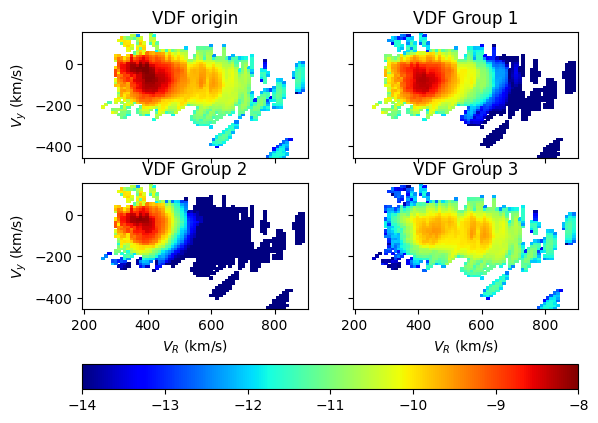

In [126]:
fig = plt.figure()
fig,axs = plt.subplots(2,2,sharex=True,sharey=True)
cax=axs[0][0].pcolor(-vx_lst,vy_lst,np.log10(grid_vdf[:,:,25]).T,cmap='jet',vmin=-14,vmax=-8)
axs[0][0].set_title('VDF origin')
axs[0][0].set_ylabel('$V_y$ (km/s)')
axs[0][1].pcolor(-vx_lst,vy_lst,np.log10(grid_g1_vdf[:,:,25]).T,cmap='jet',vmin=-14,vmax=-8)
axs[0][1].set_title('VDF Group 1')
axs[1][0].pcolor(-vx_lst,vy_lst,np.log10(grid_g2_vdf[:,:,25]).T,cmap='jet',vmin=-14,vmax=-8)
axs[1][0].set_title('VDF Group 2')
axs[1][0].set_ylabel('$V_y$ (km/s)')
axs[1][0].set_xlabel('$V_R$ (km/s)')
axs[1][1].pcolor(-vx_lst,vy_lst,np.log10(grid_g3_vdf[:,:,25]).T,cmap='jet',vmin=-14,vmax=-8)
axs[1][1].set_title('VDF Group 3')
axs[1][1].set_xlabel('$V_R$ (km/s)')
fig.colorbar(cax, ax=axs, orientation='horizontal', fraction=.1)

In [85]:
axs[0]

array([<Axes: >, <Axes: >], dtype=object)

In [ ]:
np.linspace(-200,-900,36)